In [2]:
import math
import os
import copy
import time
import warnings
import torch

from tempfile import TemporaryDirectory
from typing import Tuple
from typing import List
from typing import Optional, Tuple
from typing import Optional, Any, Union, Callable

from torch import nn, Tensor
from torch.nn import functional as F
from torch.utils.data import dataset
from transformers import PreTrainedModel
from torch.nn.modules.linear import NonDynamicallyQuantizableLinear
from torch.nn.init import constant_, xavier_normal_, xavier_uniform_
from torch.nn.parameter import Parameter
from torch.nn.modules.module import Module
from torch.nn.modules.container import ModuleList
from torch.nn.modules.dropout import Dropout
from torch.nn.modules.linear import Linear
from torch.nn.modules.normalization import LayerNorm
from torchtext.datasets import WikiText2
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator

from transformers import PretrainedConfig
from transformers import OpenAIGPTConfig, AutoTokenizer, OpenAIGPTLMHeadModel 

from datasets import load_dataset
import matplotlib.pyplot as plt
import common_utils

In [25]:
# Try modular arthemetics

N = 7

# fill in a table
m = torch.zeros(N, N)

a = 0.3
b = -0.4

subset = [3,4]

for i in range(N):
    for j in range(N):
        k = (i + j + N) % N
        if i in subset or j in subset:
            m[k, i] += a
            m[k, j] += b
        


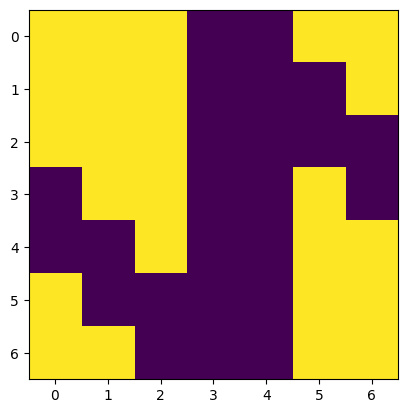

In [26]:
plt.imshow(m)

In [27]:
m

tensor([[ 0.0000,  0.0000,  0.0000, -0.1000, -0.1000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000, -0.1000, -0.1000, -0.1000,  0.0000],
        [ 0.0000,  0.0000,  0.0000, -0.1000, -0.1000, -0.1000, -0.1000],
        [-0.1000,  0.0000,  0.0000, -0.1000, -0.1000,  0.0000, -0.1000],
        [-0.1000, -0.1000,  0.0000, -0.1000, -0.1000,  0.0000,  0.0000],
        [ 0.0000, -0.1000, -0.1000, -0.1000, -0.1000,  0.0000,  0.0000],
        [ 0.0000,  0.0000, -0.1000, -0.1000, -0.1000,  0.0000,  0.0000]])

In [34]:
# Check the svd of a circulant matrix

A = torch.FloatTensor(
    [[0, 1, 2, 3], [3, 0, 1, 2], [2, 3, 0, 1], [1, 2, 3, 0]]
)


In [35]:
A

tensor([[0., 1., 2., 3.],
        [3., 0., 1., 2.],
        [2., 3., 0., 1.],
        [1., 2., 3., 0.]])

In [36]:
U, D, V = torch.svd(A)

In [37]:
U

tensor([[-0.5000,  0.5000, -0.5000, -0.5000],
        [-0.5000, -0.5000, -0.5000,  0.5000],
        [-0.5000, -0.5000,  0.5000, -0.5000],
        [-0.5000,  0.5000,  0.5000,  0.5000]])

In [38]:
V

tensor([[-5.0000e-01, -7.0711e-01, -0.0000e+00,  5.0000e-01],
        [-5.0000e-01,  9.7188e-08,  7.0711e-01, -5.0000e-01],
        [-5.0000e-01,  7.0711e-01, -2.7104e-07,  5.0000e-01],
        [-5.0000e-01, -1.8593e-07, -7.0711e-01, -5.0000e-01]])

In [44]:
A.t() @ U[:,3]

tensor([ 1.0000, -1.0000,  1.0000, -1.0000])

In [52]:
u = torch.view_as_complex(U[:,1:3].contiguous())

In [53]:
u

tensor([ 0.5000-0.5000j, -0.5000-0.5000j, -0.5000+0.5000j,  0.5000+0.5000j])

In [56]:
A.to(torch.cfloat) @ u

tensor([ 8.3447e-07+2.0000e+00j,  2.0000e+00-3.5763e-07j,
        -2.3842e-07-2.0000e+00j, -2.0000e+00+5.9605e-07j])

In [74]:
n = 4
r = 1

u = torch.zeros(n, 2)

angles = torch.linspace(0, 1, n + 1)[:-1] * 2 * math.pi * r
u[:,0] = angles.cos()
u[:,1] = angles.sin()

u = torch.view_as_complex(u)

print(u)

print(A.to(torch.cfloat) @ u)

tensor([ 1.0000e+00+0.0000e+00j, -4.3711e-08+1.0000e+00j,
        -1.0000e+00-8.7423e-08j,  1.1925e-08-1.0000e+00j])
tensor([-2.0000-2.0000j,  2.0000-2.0000j,  2.0000+2.0000j, -2.0000+2.0000j])


In [72]:
u

tensor([ 1.0000e+00+0.0000e+00j,  1.1925e-08-1.0000e+00j,
        -1.0000e+00-2.3850e-08j, -3.5775e-08+1.0000e+00j])

In [68]:
angles

tensor([0.0000, 1.5708, 3.1416, 4.7124])

In [67]:
angles / 2 / math.pi

tensor([0.0000, 0.2500, 0.5000, 0.7500])

In [83]:
D, V = torch.linalg.eig(A.t() @ A)
print(V)
print(D)

tensor([[ 5.0000e-01+0.j,  7.0711e-01+0.j, -5.0000e-01+0.j,  3.3784e-02+0.j],
        [ 5.0000e-01+0.j,  3.8313e-07+0.j,  5.0000e-01+0.j, -7.0630e-01+0.j],
        [ 5.0000e-01+0.j, -7.0711e-01+0.j, -5.0000e-01+0.j, -3.3784e-02+0.j],
        [ 5.0000e-01+0.j,  1.2238e-07+0.j,  5.0000e-01+0.j,  7.0630e-01+0.j]])
tensor([36.0000+0.j,  8.0000+0.j,  4.0000+0.j,  8.0000+0.j])


In [82]:
D, V = torch.linalg.eig(A @ A.t())
print(V)
print(D)

tensor([[ 5.0000e-01+0.j,  7.0711e-01+0.j, -5.0000e-01+0.j,  3.3784e-02+0.j],
        [ 5.0000e-01+0.j,  3.8313e-07+0.j,  5.0000e-01+0.j, -7.0630e-01+0.j],
        [ 5.0000e-01+0.j, -7.0711e-01+0.j, -5.0000e-01+0.j, -3.3784e-02+0.j],
        [ 5.0000e-01+0.j,  1.2238e-07+0.j,  5.0000e-01+0.j,  7.0630e-01+0.j]])
tensor([36.0000+0.j,  8.0000+0.j,  4.0000+0.j,  8.0000+0.j])


In [89]:
V @ D.diag() @ V.t()

tensor([[14.0091+0.j,  7.8091+0.j,  5.9909+0.j,  8.1909+0.j],
        [ 7.8091+0.j, 13.9909+0.j,  8.1909+0.j,  6.0091+0.j],
        [ 5.9909+0.j,  8.1909+0.j, 14.0091+0.j,  7.8091+0.j],
        [ 8.1909+0.j,  6.0091+0.j,  7.8091+0.j, 13.9909+0.j]])

In [85]:
D.sqrt().diag()

tensor([[6.0000+0.j, 0.0000+0.j, 0.0000+0.j, 0.0000+0.j],
        [0.0000+0.j, 2.8284+0.j, 0.0000+0.j, 0.0000+0.j],
        [0.0000+0.j, 0.0000+0.j, 2.0000+0.j, 0.0000+0.j],
        [0.0000+0.j, 0.0000+0.j, 0.0000+0.j, 2.8284+0.j]])

In [87]:
A @ A.t()

tensor([[14.,  8.,  6.,  8.],
        [ 8., 14.,  8.,  6.],
        [ 6.,  8., 14.,  8.],
        [ 8.,  6.,  8., 14.]])

In [90]:
V.t() @ V

tensor([[ 1.0000e+00+0.j, -2.8218e-08+0.j, -1.3411e-07+0.j, -5.9605e-08+0.j],
        [-2.8218e-08+0.j,  1.0000e+00+0.j,  1.8040e-07+0.j,  4.7778e-02+0.j],
        [-1.3411e-07+0.j,  1.8040e-07+0.j,  1.0000e+00+0.j, -5.9605e-08+0.j],
        [-5.9605e-08+0.j,  4.7778e-02+0.j, -5.9605e-08+0.j,  1.0000e+00+0.j]])

In [92]:
U, D, V = torch.linalg.svd(A)
print(U)
print(V)
print(D)

tensor([[-0.5000,  0.5000, -0.5000, -0.5000],
        [-0.5000, -0.5000, -0.5000,  0.5000],
        [-0.5000, -0.5000,  0.5000, -0.5000],
        [-0.5000,  0.5000,  0.5000,  0.5000]])
tensor([[-5.0000e-01, -5.0000e-01, -5.0000e-01, -5.0000e-01],
        [-7.0711e-01,  9.7188e-08,  7.0711e-01, -1.8593e-07],
        [-0.0000e+00,  7.0711e-01, -2.7104e-07, -7.0711e-01],
        [ 5.0000e-01, -5.0000e-01,  5.0000e-01, -5.0000e-01]])
tensor([6.0000, 2.8284, 2.8284, 2.0000])


In [94]:
U @ D.diag() @ V

tensor([[ 1.1921e-07,  1.0000e+00,  2.0000e+00,  3.0000e+00],
        [ 3.0000e+00, -1.1921e-07,  1.0000e+00,  2.0000e+00],
        [ 2.0000e+00,  3.0000e+00,  1.1921e-07,  1.0000e+00],
        [ 1.0000e+00,  2.0000e+00,  3.0000e+00,  3.5763e-07]])

In [98]:
A @ A.t()

tensor([[14.,  8.,  6.,  8.],
        [ 8., 14.,  8.,  6.],
        [ 6.,  8., 14.,  8.],
        [ 8.,  6.,  8., 14.]])

In [96]:
V.t() @ D.pow(2).diag() @ V

tensor([[14.0000,  8.0000,  6.0000,  8.0000],
        [ 8.0000, 14.0000,  8.0000,  6.0000],
        [ 6.0000,  8.0000, 14.0000,  8.0000],
        [ 8.0000,  6.0000,  8.0000, 14.0000]])

In [97]:
V

tensor([[-5.0000e-01, -5.0000e-01, -5.0000e-01, -5.0000e-01],
        [-7.0711e-01,  9.7188e-08,  7.0711e-01, -1.8593e-07],
        [-0.0000e+00,  7.0711e-01, -2.7104e-07, -7.0711e-01],
        [ 5.0000e-01, -5.0000e-01,  5.0000e-01, -5.0000e-01]])

In [99]:
A.t() @ A

tensor([[14.,  8.,  6.,  8.],
        [ 8., 14.,  8.,  6.],
        [ 6.,  8., 14.,  8.],
        [ 8.,  6.,  8., 14.]])

In [100]:
A

tensor([[0., 1., 2., 3.],
        [3., 0., 1., 2.],
        [2., 3., 0., 1.],
        [1., 2., 3., 0.]])

In [102]:
A.t() @ A - A @ A.t()

tensor([[0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.]])

In [146]:
# Compute the matrix representation of normal subgroup
def apply_permutation(perm, sequence):
    # Create a copy of the sequence to avoid modifying the original
    result = sequence[:]
    
    for cycle in perm:
        cycle_len = len(cycle)
        for i in range(cycle_len):
            result[cycle[(i + 1) % cycle_len]] = sequence[cycle[i]]
    
    return result

def unique_rep(perm):
    new_perm = []
    for cycle in perm:
        # rotation the cycle so that the smallest number goes first
        min_index = cycle.index(min(cycle))
        cycle = cycle[min_index:] + cycle[:min_index]
        new_perm.append(tuple(cycle))
    
    # sort the the cycle to keep uniquenss
    new_perm.sort()
    return tuple(new_perm)       
        

def permutation_product(perm1, perm2, n, start1=True):
    if start1:
        perm1 = tuple(tuple(a - 1 for a in cycle) for cycle in perm1)
        perm2 = tuple(tuple(a - 1 for a in cycle) for cycle in perm2)
    
    # Assume permutations are applied to the range 0 to n-1
    # n = max(max(cycle) for cycle in perm1 + perm2) + 1
    sequence = list(range(n))
    
    # Apply the first permutation
    result_after_perm1 = apply_permutation(perm1, sequence)
    # print(result_after_perm1)
    
    # Apply the second permutation to the result
    final_result = apply_permutation(perm2, result_after_perm1)
    # print(final_result)
    
    # Extract the cycles from the final result
    visited = [False] * n
    product = []
    
    for i in range(n):
        if not visited[i]:
            cycle = []
            x = i
            while not visited[x]:
                visited[x] = True
                cycle.append(x)
                x = final_result[x]
            if len(cycle) > 1:
                cycle = cycle[::-1]
                if start1:
                    cycle = [c + 1 for c in cycle]                
                product.append(cycle)

    return unique_rep(product)

def permutation_inverse(perm):
    # reverse all circles. 
    return unique_rep(cycle[::-1] for cycle in perm)
    

# Example usage:
perm1 = [[1, 3], [2, 4]]
perm2 = [[1, 2, 3]]
print(permutation_product(perm1, perm2, 4)) 

((2, 4, 3),)


In [147]:
# construct permutation group and compute its multiplication table.
from collections import defaultdict
import torch

class Group:
    def __init__(self, gens, n):
        # Generate all group members 
        mem2idx = { k : v for v, k in enumerate(gens) }
        idx2mem = list(gens)

        # multplication table.
        cayley_table = dict()
        has_new_element = True

        while has_new_element:
            has_new_element = False
            for i, m1 in enumerate(idx2mem):
                for j, m2 in enumerate(idx2mem):
                    if (i,j) in cayley_table:
                        continue

                    # multiply 
                    m = permutation_product(m1, m2, n)
                    if m in mem2idx:
                        cayley_table[(i, j)] = mem2idx[m]
                    else:
                        # new element
                        idx2mem.append(m)
                        new_idx = len(idx2mem) - 1
                        mem2idx[m] = new_idx
                        cayley_table[(i, j)] = new_idx
                        has_new_element = True
                        # print(f"new element: {m}")
                        break

        self.idx2mem = idx2mem
        self.mem2idx = mem2idx
        self.n = n
        self.sz = len(idx2mem)
        
        self.cayley = torch.LongTensor(self.sz, self.sz)
        for k, v in cayley_table.items():
            self.cayley[k[0],k[1]] = v
            
    def reorder(self, ordered_grp):
        # new idx to old idx
        assert len(ordered_grp) == self.sz, f"Size should match! len(ordered_grp) {len(ordered_grp)} != {self.sz}" 
        
        new2old = self.grp2idx(ordered_grp)
        # old idx to new idx
        old2new = [ None ] * self.sz
        for i, k in enumerate(new2old):
            old2new[k] = i
        
        self.idx2mem = ordered_grp
        self.mem2idx = { h : i for i, h in enumerate(ordered_grp) }
        # Map the cayley table
        new_cayley = torch.LongTensor(self.sz, self.sz)
        for i in range(self.sz):
            for j in range(self.sz):
                new_cayley[i,j] = old2new[self.cayley[new2old[i], new2old[j]]]
        self.cayley = new_cayley
        
    def grp2idx(self, grp):
        return [ self.mem2idx[h] for h in grp ]
    
    def idx2grp(self, indices):
        return [ self.idx2mem[i] for i in indices ]
        
        
    def compute_coset(self, subgroup):
        subgroup_indices = self.grp2idx(subgroup)
        # Compute the coset regarding to the subgroup
        
        def order_coset(coset):
            coset_l = list(coset)
            coset_l.sort()
            return tuple(coset_l)
        
        result = []
        coset_rev_map = defaultdict(list)
        for i, m in enumerate(self.idx2mem):
            coset = [ self.cayley[i,j].item() for j in subgroup_indices ]
            result.append(coset)
            coset_rev_map[order_coset(coset)].append(i)
            
        # group coset together. 
        all_result = []
        for _, grouped in coset_rev_map.items():
            curr_group = { self.idx2mem[i] : self.idx2grp(result[i]) for i in grouped }           
            all_result.append(curr_group)
            
        return all_result
    
    def get_matrix(self, m):
        i = self.mem2idx[m]
        R = torch.zeros(self.sz, self.sz)
        for j, k in enumerate(self.cayley[i]):
            R[k, j] = 1
        return R
        
gens = [((1,2),), ((1,2,3,4),)]
S4 = Group(gens, 4)

In [148]:
# normal subgroup
subgroup = [(), ((1,2),(3,4)), ((1,3),(2,4)), ((1,4),(2,3))]

all_cosets = S4.compute_coset(subgroup)

In [149]:
print(subgroup)
ordered_group = []

offset = permutation_inverse(((1, 3), (2, 4)))

for i, coset_group in enumerate(all_cosets):
    print(f"Coset_group{i}: ")
    ks = []
    for k, v in coset_group.items():
        print(f"{k}: \n      {v}\n")
        ks.append(k)
    
    # Using k to construct orders
    k = permutation_product(ks[1], offset, S4.n)
    print(f"Picked {k}")
    for g in subgroup:
        entry = permutation_product(g, k, S4.n)
        print(f"Added entry: {entry}")
        ordered_group.append(entry)
    print()
    
# compute the R_g matrix following the ordering of co-set
S4.reorder(ordered_group)


[(), ((1, 2), (3, 4)), ((1, 3), (2, 4)), ((1, 4), (2, 3))]
Coset_group0: 
((1, 2),): 
      [((1, 2),), ((3, 4),), ((1, 4, 2, 3),), ((1, 3, 2, 4),)]

((1, 3, 2, 4),): 
      [((1, 3, 2, 4),), ((1, 4, 2, 3),), ((3, 4),), ((1, 2),)]

((3, 4),): 
      [((3, 4),), ((1, 2),), ((1, 3, 2, 4),), ((1, 4, 2, 3),)]

((1, 4, 2, 3),): 
      [((1, 4, 2, 3),), ((1, 3, 2, 4),), ((1, 2),), ((3, 4),)]

Picked ((3, 4),)
Added entry: ((3, 4),)
Added entry: ((1, 2),)
Added entry: ((1, 4, 2, 3),)
Added entry: ((1, 3, 2, 4),)

Coset_group1: 
((1, 2, 3, 4),): 
      [((1, 2, 3, 4),), ((2, 4),), ((1, 4, 3, 2),), ((1, 3),)]

((1, 3),): 
      [((1, 3),), ((1, 4, 3, 2),), ((2, 4),), ((1, 2, 3, 4),)]

((1, 4, 3, 2),): 
      [((1, 4, 3, 2),), ((1, 3),), ((1, 2, 3, 4),), ((2, 4),)]

((2, 4),): 
      [((2, 4),), ((1, 2, 3, 4),), ((1, 3),), ((1, 4, 3, 2),)]

Picked ((2, 4),)
Added entry: ((2, 4),)
Added entry: ((1, 4, 3, 2),)
Added entry: ((1, 3),)
Added entry: ((1, 2, 3, 4),)

Coset_group2: 
(): 
      [(), ((1,

Coset 0: 


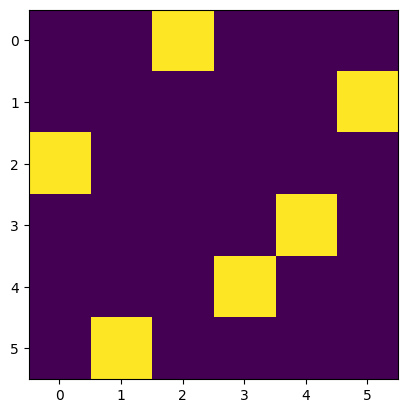

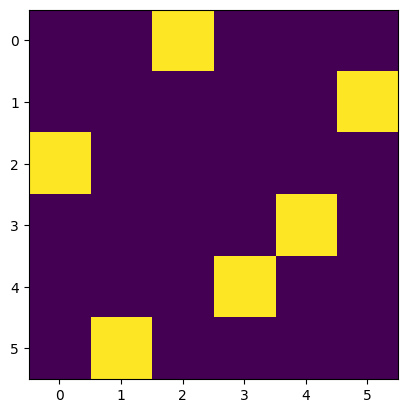

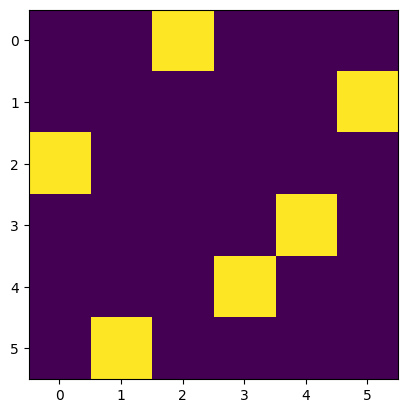

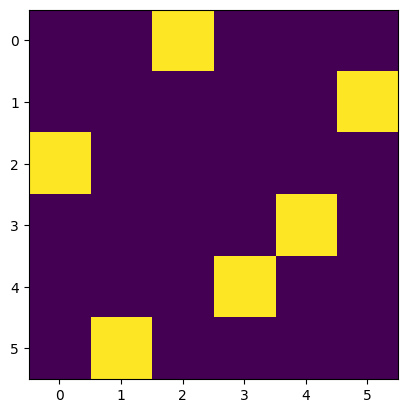

Coset 1: 


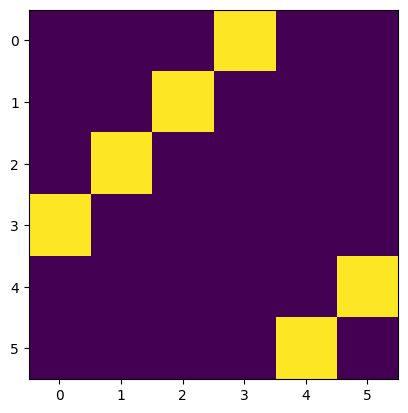

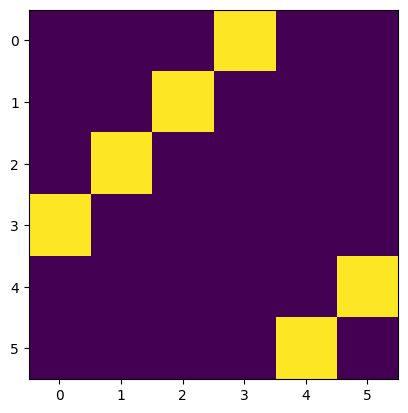

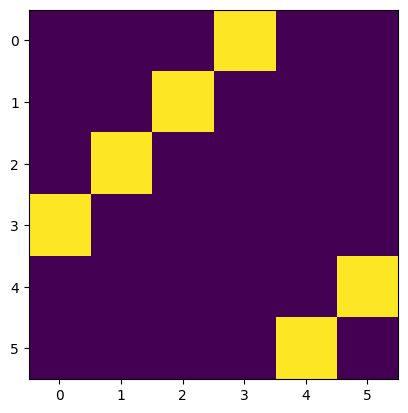

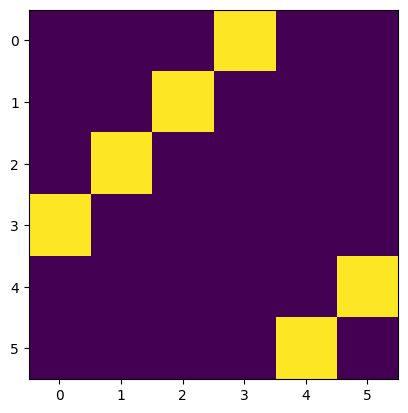

Coset 2: 


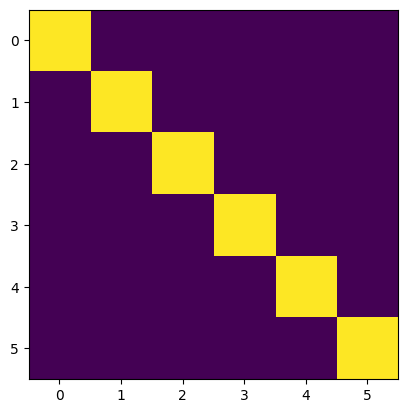

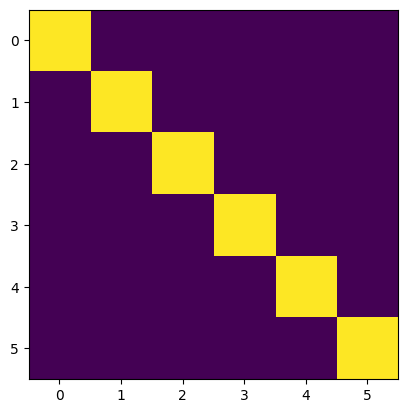

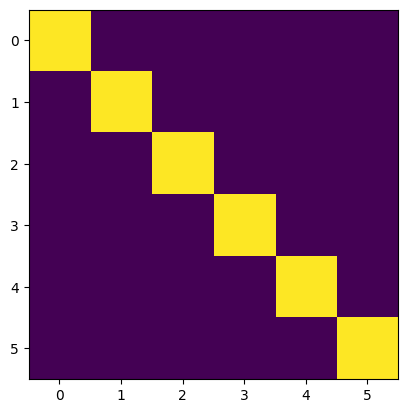

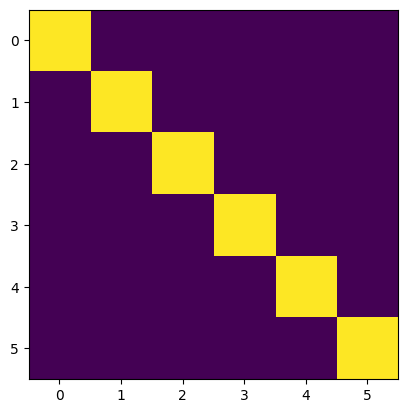

Coset 3: 


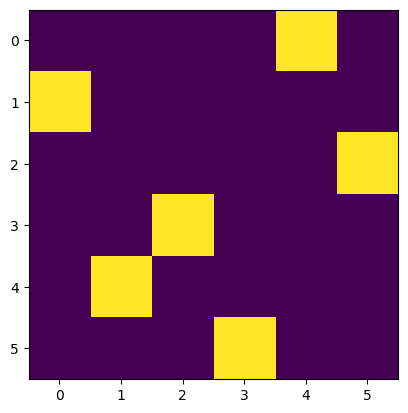

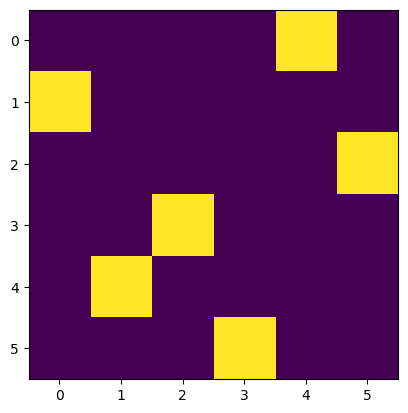

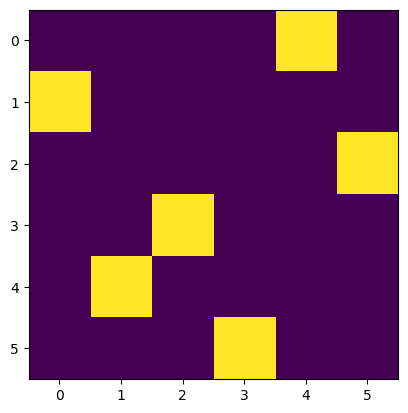

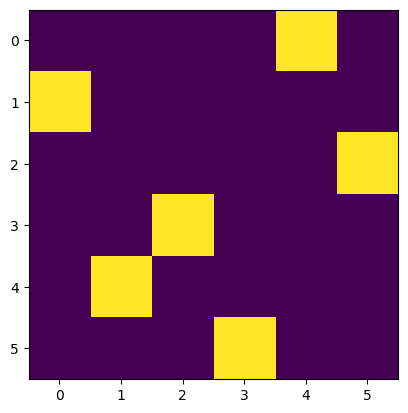

Coset 4: 


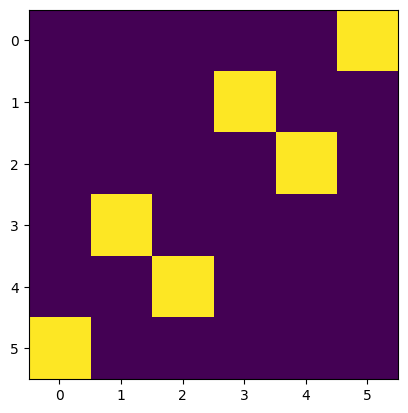

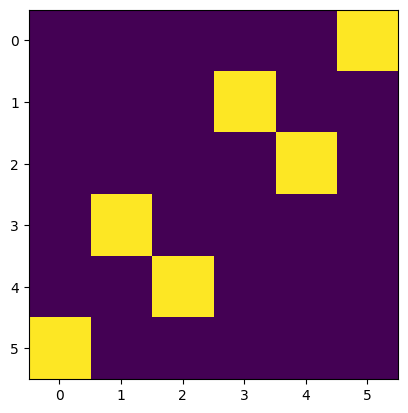

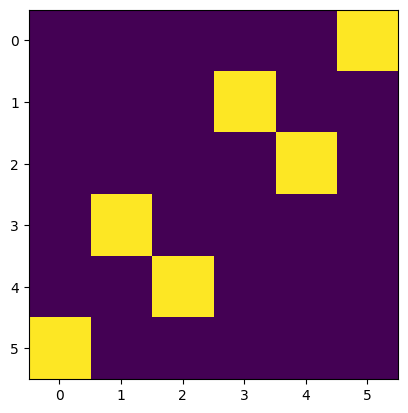

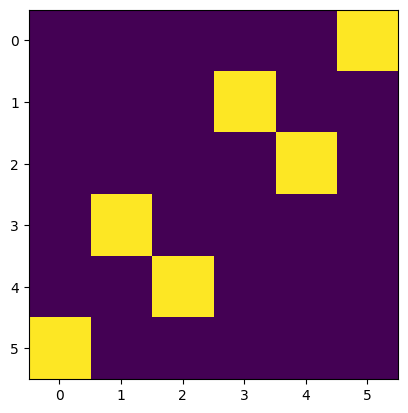

Coset 5: 


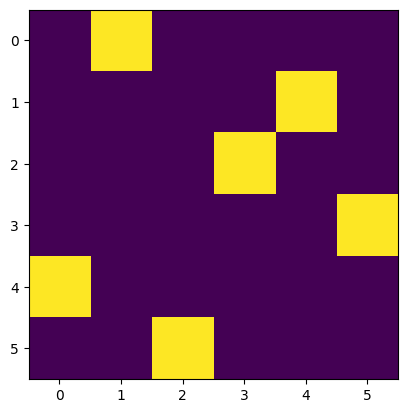

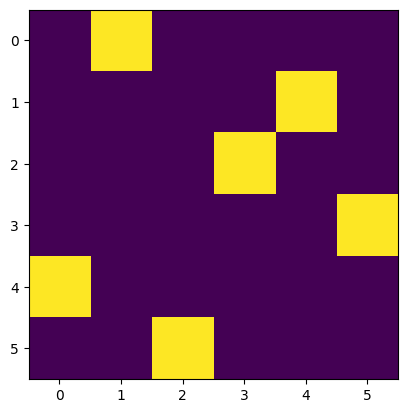

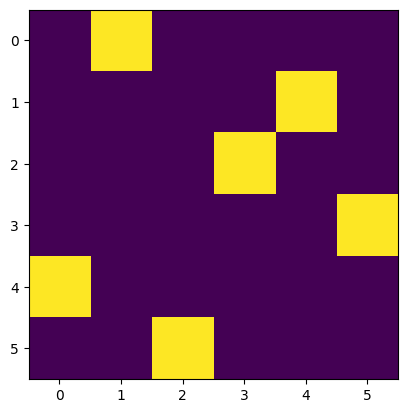

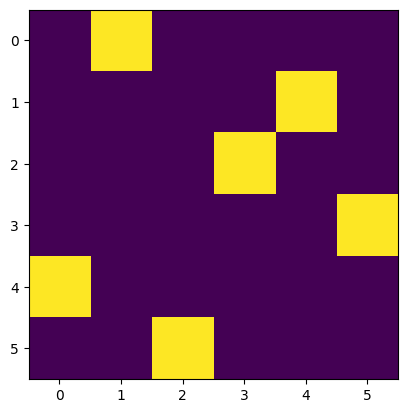

In [158]:
# g = ((1,3,2),)
C0 = torch.zeros(24, 6)
for i in range(6):
    C0[4*i:4*(i+1),i] = 1

for i, coset_group in enumerate(all_cosets):
    print(f"Coset {i}: ")
    for k, v in coset_group.items():
        # plt.imshow(S4.get_matrix(k))
        plt.imshow(C0.t() @ S4.get_matrix(k) @ C0)
        plt.show()

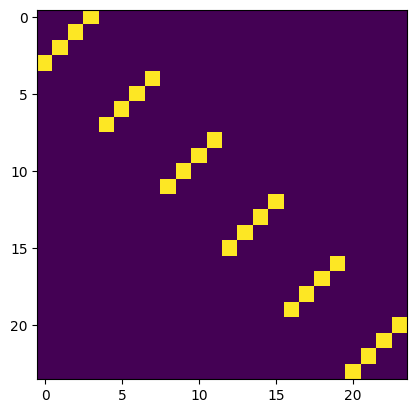

In [151]:
plt.imshow(S4.get_matrix(((1, 4), (2, 3),)))

In [271]:
print(subgroup)
# subgroup2 = [((1, 3), (2, 4)), ((1, 4), (2, 3)), (), ((1, 2), (3, 4))]
# print(subgroup)

for n in subgroup:
    nn = permutation_product(permutation_product(g, n, S4.n), permutation_inverse(g), S4.n)
    print(nn)

[(), ((1, 2), (3, 4)), ((1, 3), (2, 4)), ((1, 4), (2, 3))]
()
((1, 4), (2, 3))
((1, 2), (3, 4))
((1, 3), (2, 4))


In [340]:
# Check the spectrum of cyclic group
import random

n = 113
r1 = 0.5
r2 = 0.7

B1 = torch.zeros(n, n)
B2 = torch.zeros(n, n)

for i in range(n):
    # generate rho_g
    rho = torch.rand(n) + 0.5
    
    # rho = torch.zeros(n)
    # rho[random.randint(0, n-1)] = 1
    # rho = torch.ones(n)

    rho = rho / rho.sum() * random.random()
    
    Rg = torch.zeros(n, n)
    for j in range(n):
        Rg[j,(j+i)%n] = 1
        
    eg = torch.zeros(n)
    eg[i] = 1
        
    B1 += torch.outer(eg, rho) @ Rg
    B2 += rho.diag() @ Rg

B = B1 + B2



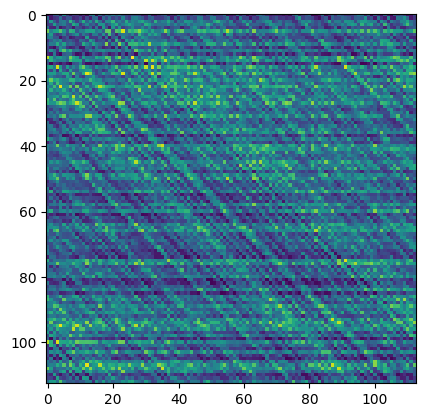

In [341]:
plt.imshow(B)

In [342]:
B

tensor([[0.0004, 0.0015, 0.0070,  ..., 0.0013, 0.0015, 0.0054],
        [0.0084, 0.0015, 0.0035,  ..., 0.0080, 0.0016, 0.0038],
        [0.0045, 0.0128, 0.0070,  ..., 0.0141, 0.0087, 0.0068],
        ...,
        [0.0042, 0.0028, 0.0132,  ..., 0.0013, 0.0016, 0.0068],
        [0.0045, 0.0050, 0.0024,  ..., 0.0059, 0.0015, 0.0038],
        [0.0084, 0.0128, 0.0134,  ..., 0.0059, 0.0079, 0.0054]])

In [343]:
Rg

tensor([[0., 0., 0.,  ..., 0., 0., 1.],
        [1., 0., 0.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 1., 0., 0.],
        [0., 0., 0.,  ..., 0., 1., 0.]])

In [324]:
eg

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 1.])

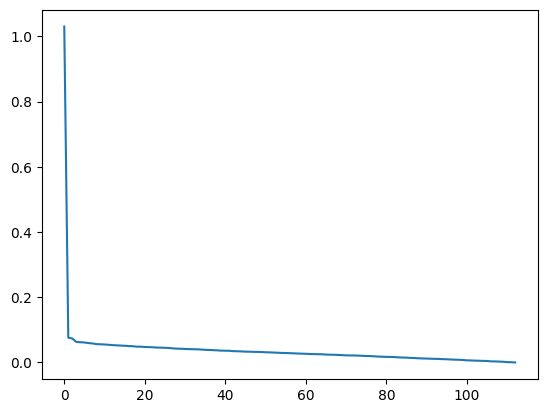

In [344]:
U, D, V = torch.linalg.svd(B)
plt.plot(D)

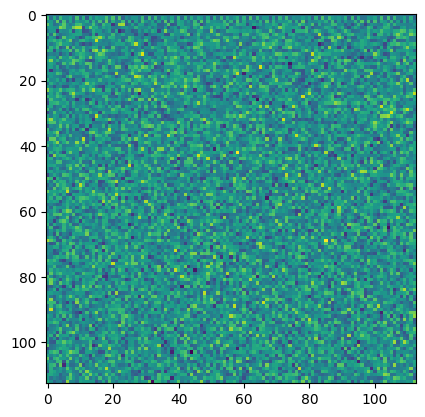

In [345]:
plt.imshow(V)

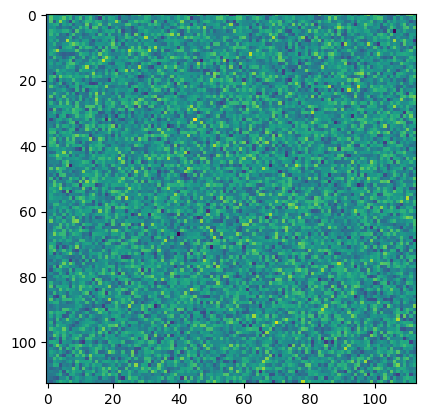

In [311]:
plt.imshow(U)

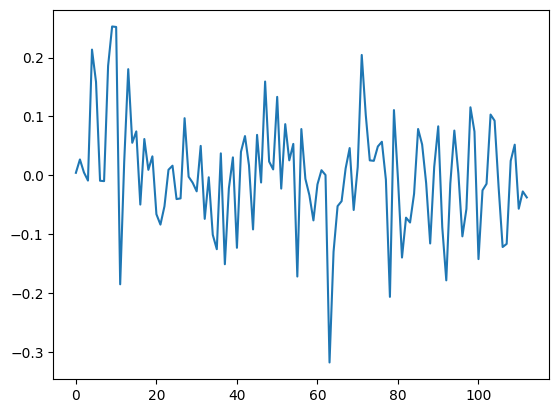

In [395]:
plt.plot(V[4,:])

In [316]:
B

tensor([[2., 2., 2.,  ..., 2., 2., 2.],
        [2., 2., 2.,  ..., 2., 2., 2.],
        [2., 2., 2.,  ..., 2., 2., 2.],
        ...,
        [2., 2., 2.,  ..., 2., 2., 2.],
        [2., 2., 2.,  ..., 2., 2., 2.],
        [2., 2., 2.,  ..., 2., 2., 2.]])

In [117]:
model = torch.load("/private/home/yuandong/luckmatters/ssl/real-dataset/model.pt")

In [122]:
embedding = model["embedding.weight"].cpu()
u = model["layer1.weight"].cpu()
v = model["layer2.weight"].cpu()
lm_head1 = model["output_layers.0.weight"].cpu()
lm_head2 = model["output_layers.1.weight"].cpu()

In [121]:
model.keys()

odict_keys(['embedding.weight', 'embedding.bias', 'layer1.weight', 'layer1.bias', 'layer2.weight', 'layer2.bias', 'output_layers.0.weight', 'output_layers.0.bias', 'output_layers.1.weight', 'output_layers.1.bias'])

<IPython.core.display.Javascript object>


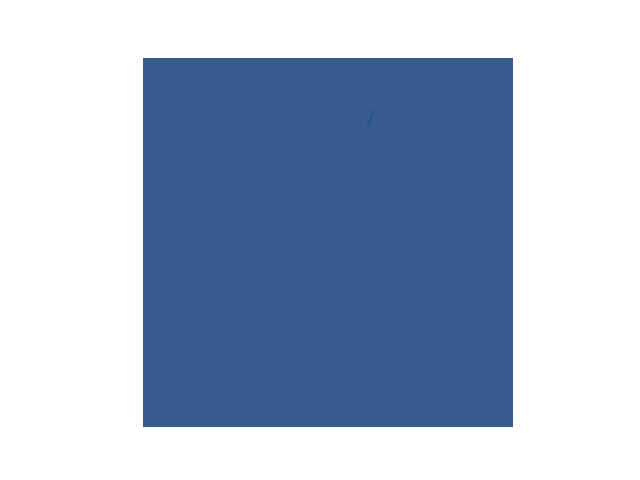

In [486]:
%matplotlib notebook

fig, ax = plt.subplots(subplot_kw={"projection": "3d"})

import numpy as np
X = np.linspace(0, 1, 7)
Y = np.linspace(0, 1, 23)
X, Y = np.meshgrid(X, Y)

ax.plot_surface(X, Y, embedding[2,:].reshape(23, 7))

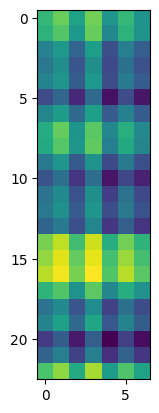

In [127]:
# plt.plot(embedding[1,:])

plt.imshow(embedding[5,:].reshape(23,7))

In [19]:
torch.svd(embedding)

torch.return_types.svd(
U=tensor([[ 0.1283, -0.1924,  0.2304, -0.5307, -0.2107,  0.1635, -0.2389,  0.1780,
          0.4408, -0.1958,  0.0778,  0.1010,  0.2783,  0.0581, -0.0128, -0.3492],
        [ 0.0962, -0.1069, -0.0784,  0.4406, -0.3394, -0.0630, -0.3884,  0.0814,
          0.0325,  0.2236,  0.2270,  0.4011,  0.0712,  0.4427, -0.1798,  0.0746],
        [ 0.0122,  0.1004, -0.0719, -0.2443,  0.4678, -0.1986,  0.0223,  0.3550,
          0.1332,  0.3990, -0.1661,  0.0240, -0.2784,  0.3212, -0.3504, -0.1777],
        [-0.3613,  0.3535, -0.2025, -0.0748, -0.1465,  0.0027, -0.1145, -0.4493,
         -0.1599, -0.1875, -0.2940,  0.0855,  0.0779,  0.2121, -0.2509, -0.4392],
        [ 0.0549,  0.1226, -0.0352,  0.2222,  0.3094,  0.1980, -0.1945,  0.1395,
          0.1319, -0.5066, -0.0930,  0.0640, -0.3328,  0.3492,  0.4628, -0.0740],
        [ 0.4193, -0.2586, -0.3090,  0.0190, -0.1045, -0.1084, -0.3485, -0.2349,
          0.2133,  0.0469, -0.5553, -0.1781, -0.1734, -0.1834, -0.0408,  0.095

In [468]:
X = np.linspace(0, 1, 23)
Y = np.linspace(0, 1, 7)
X, Y = np.meshgrid(X, Y)

In [470]:
Y.shape

(7, 23)

In [488]:
plt.imshow(u)

<IPython.core.display.Javascript object>


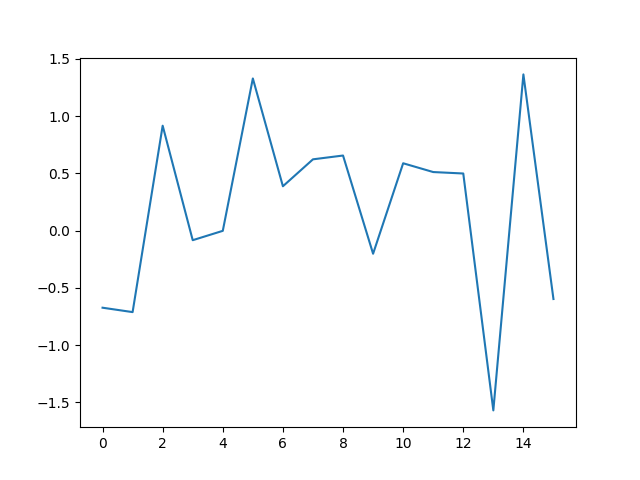

In [482]:
plt.plot(u[3,:])

(array([179., 147.,  92.,  51.,  22.,  10.,   4.,   2.,   3.,   2.]),
 array([0.        , 0.710976  , 1.42195201, 2.13292813, 2.84390402,
        3.55488014, 4.26585627, 4.97683239, 5.68780804, 6.39878416,
        7.10976028]),
 <BarContainer object of 10 artists>)

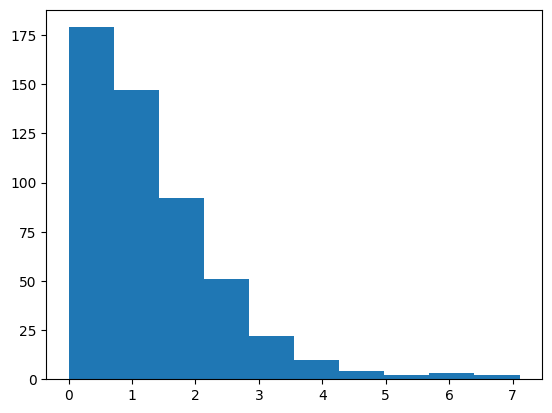

In [102]:
plt.hist(v.norm(dim=0))

(array([174., 142.,  96.,  44.,  26.,  12.,   8.,   2.,   3.,   5.]),
 array([0.        , 0.56841105, 1.1368221 , 1.70523322, 2.27364421,
        2.84205532, 3.41046643, 3.97887754, 4.54728842, 5.11569977,
        5.68411064]),
 <BarContainer object of 10 artists>)

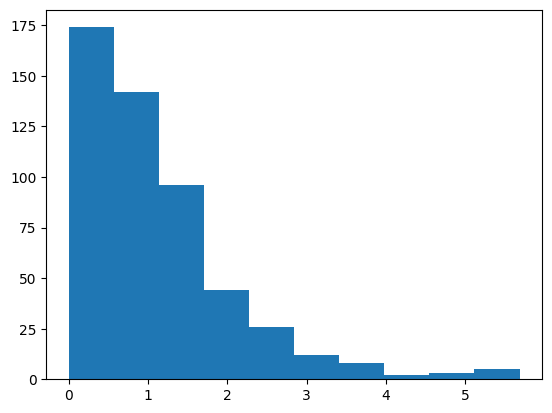

In [103]:
plt.hist(u.norm(dim=1))

In [36]:
v.size()

torch.Size([161, 512])

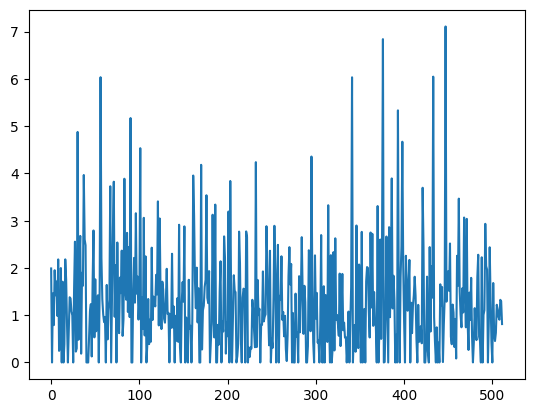

In [104]:
plt.plot(v.norm(dim=0))

In [40]:
u.size()

torch.Size([512, 16])

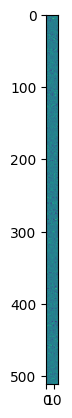

In [41]:
plt.imshow(u)

In [105]:
sel = (v.norm(dim=0) > 3)

In [144]:
embedding.shape

torch.Size([32, 161])

/tmp/ipykernel_3466571/1057472102.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure()


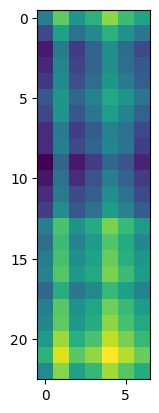

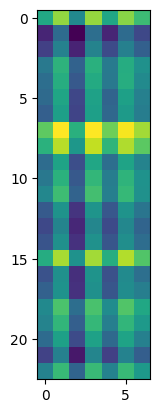

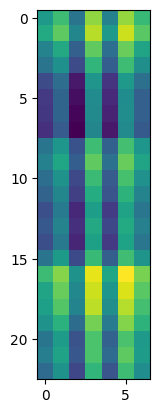

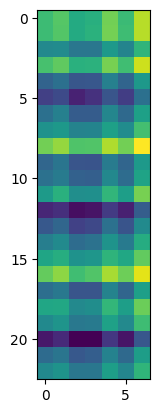

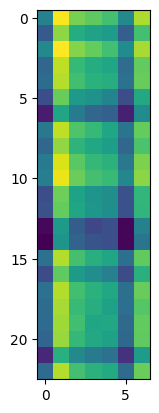

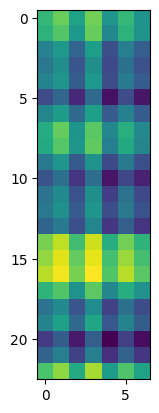

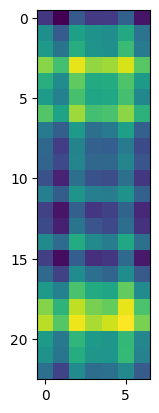

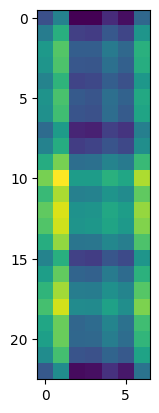

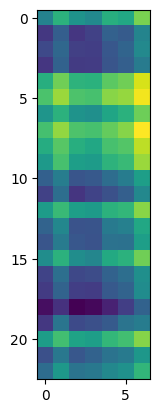

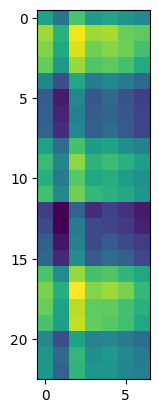

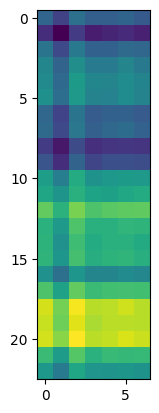

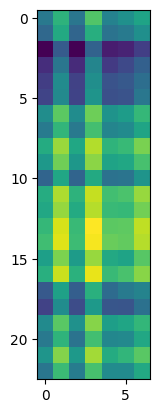

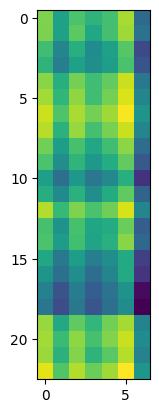

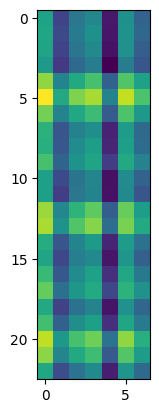

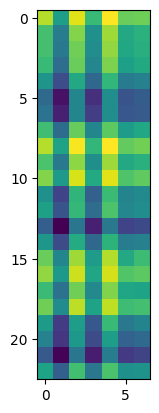

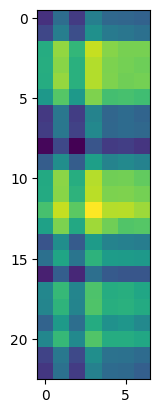

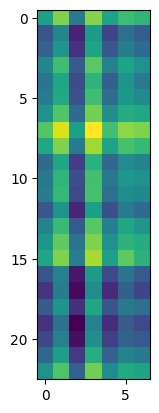

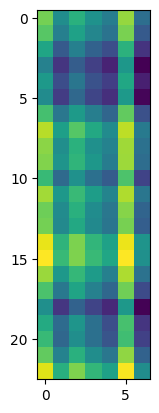

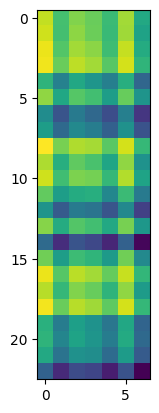

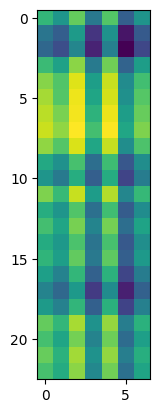

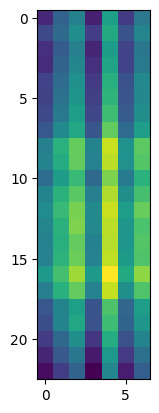

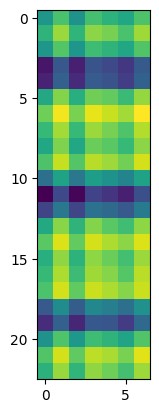

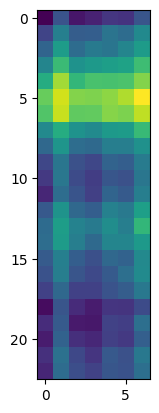

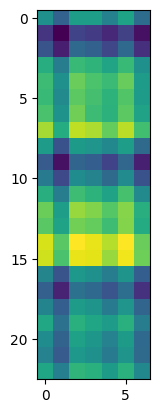

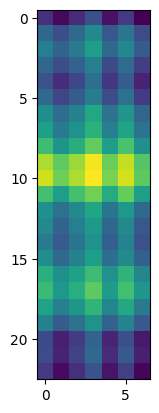

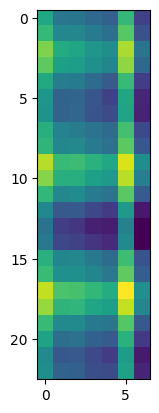

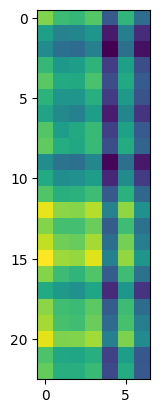

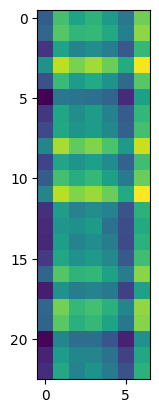

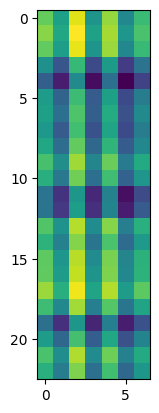

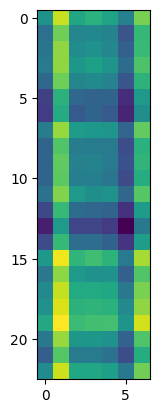

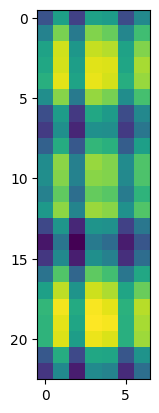

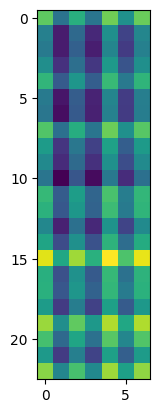

In [143]:
for i in range(embedding.shape[0]):
    plt.figure()
    # plt.subplot(1, 3, 1)
    plt.imshow(embedding[i,:].reshape(23,7))

In [129]:
ee = u[sel, :] @ embedding
gg1 = lm_head1 @ v[:,sel]
gg2 = lm_head2 @ v[:,sel]

/tmp/ipykernel_3466571/2831018321.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure()


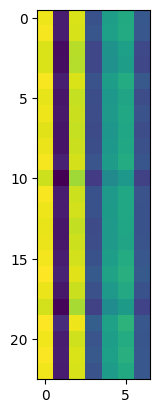

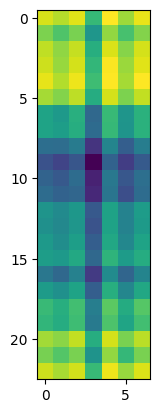

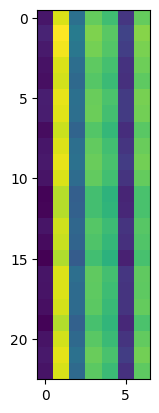

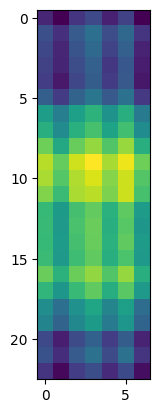

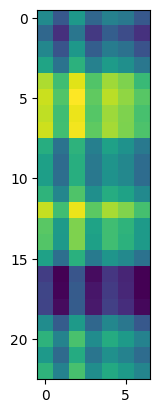

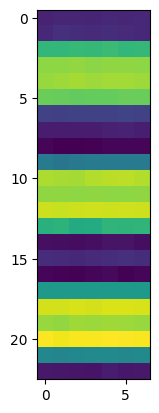

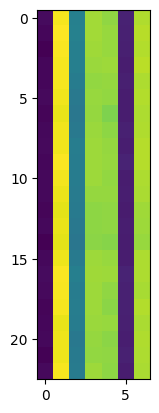

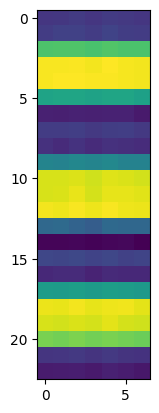

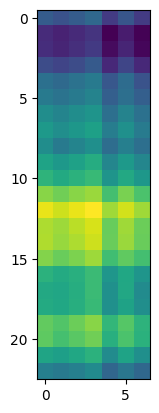

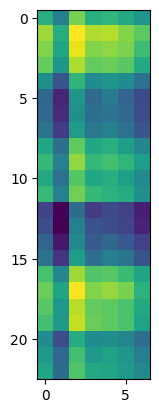

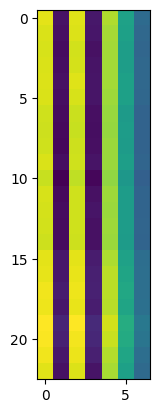

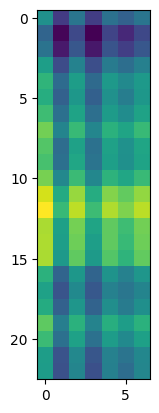

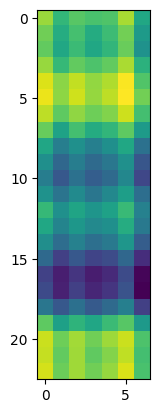

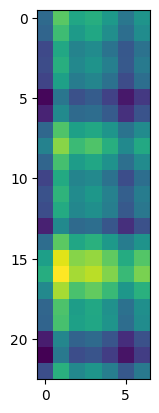

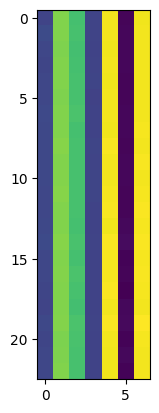

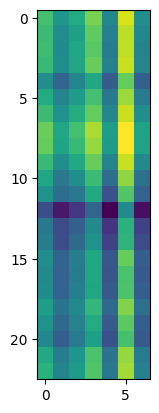

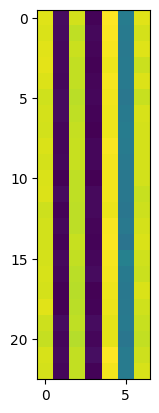

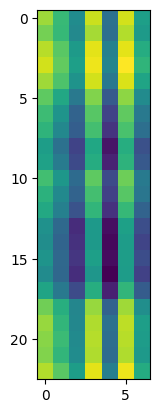

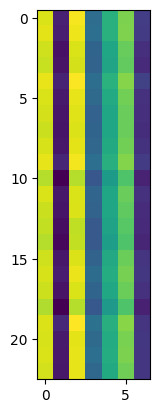

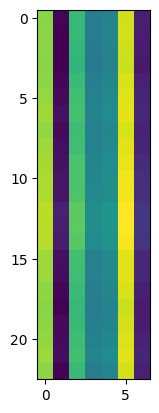

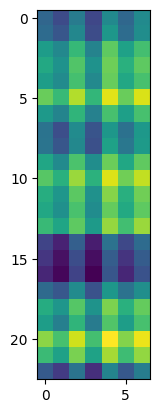

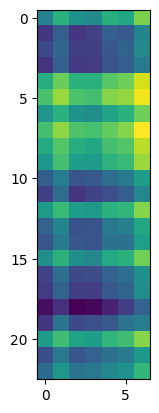

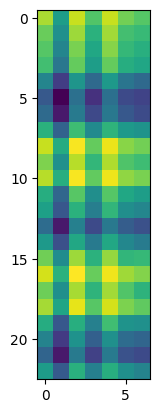

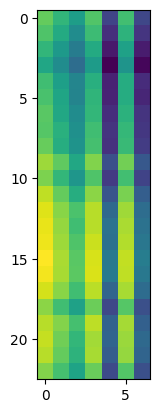

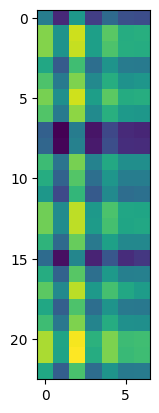

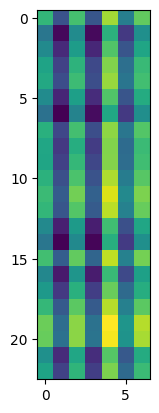

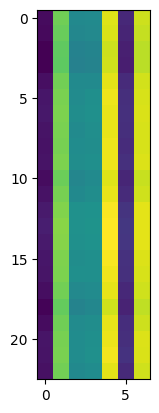

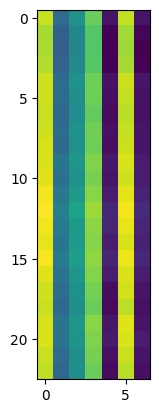

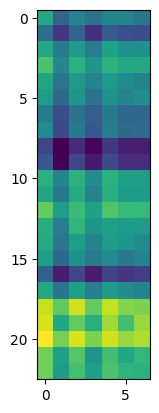

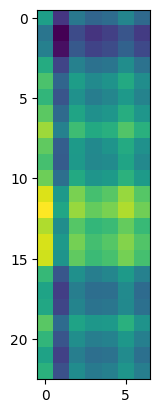

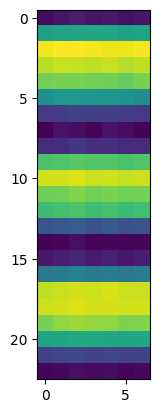

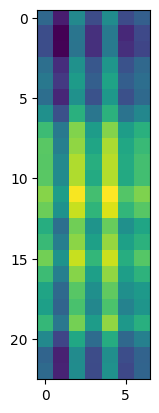

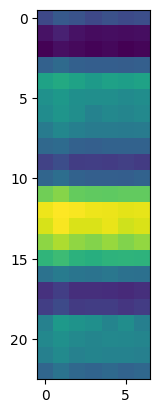

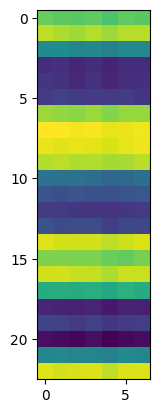

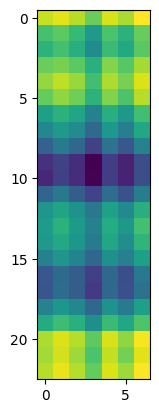

In [132]:
for i in range(ee.shape[0]):
    plt.figure()
    # plt.subplot(1, 3, 1)
    plt.imshow(ee[i,:].reshape(23,7))
    
#     plt.subplot(1, 3, 2)
#     plt.imshow(gg1[:,i])
    
#     plt.subplot(1, 3, 3)
#     plt.imshow(gg2[:,i])

In [110]:
embedding.shape

torch.Size([32, 161])

/tmp/ipykernel_3466571/1313186497.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure()


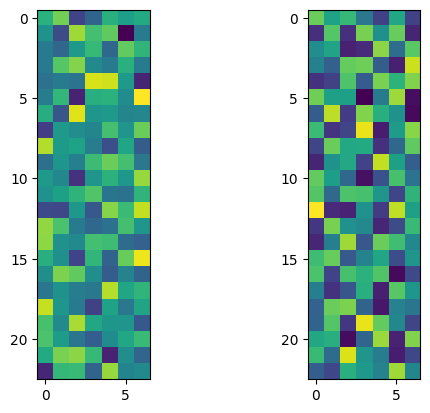

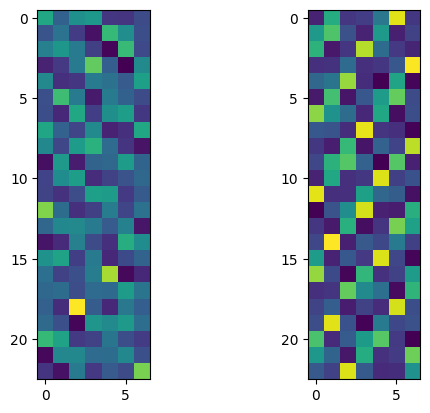

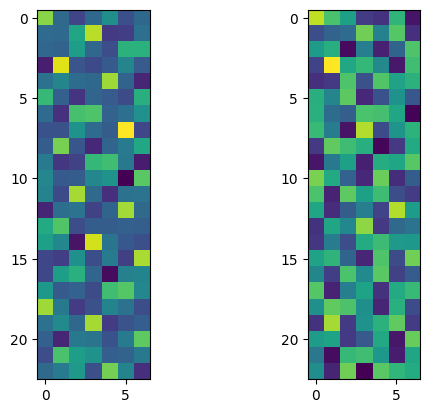

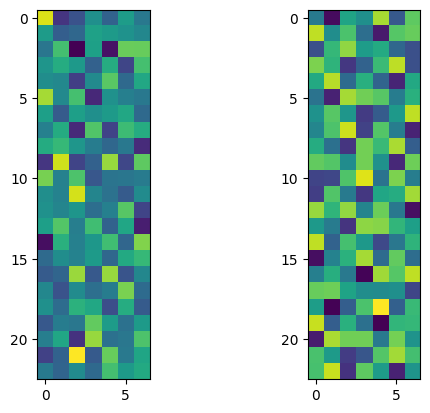

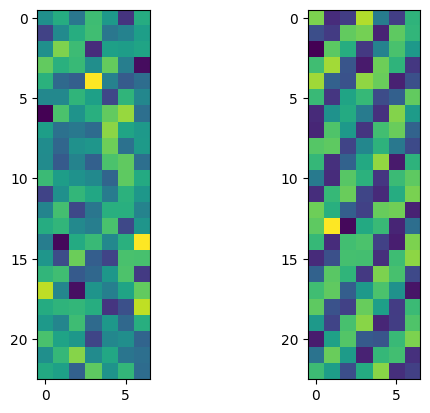

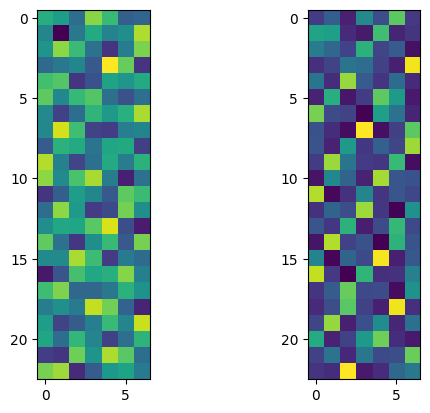

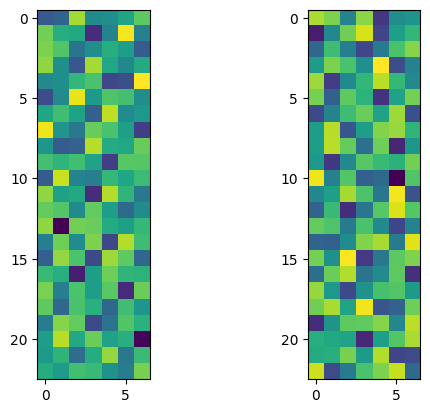

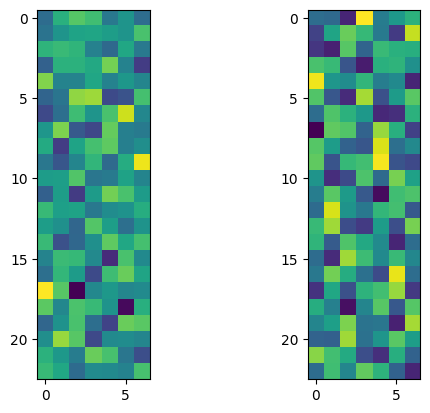

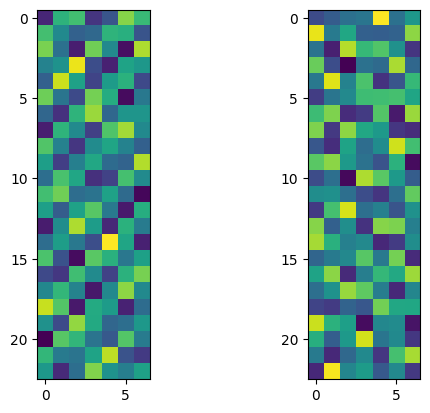

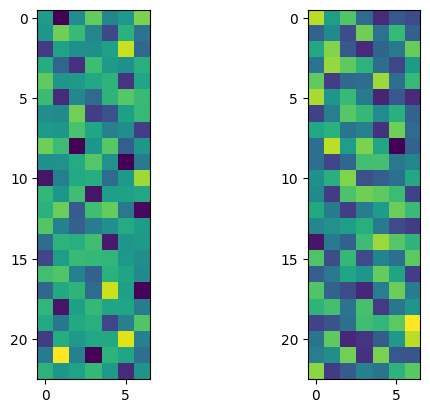

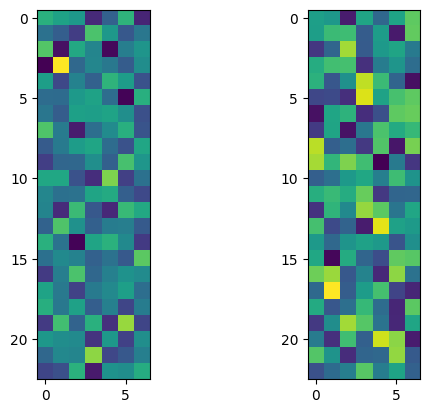

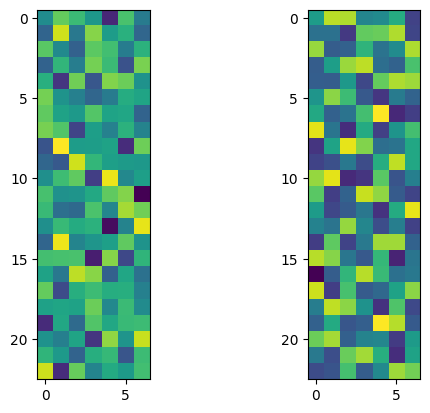

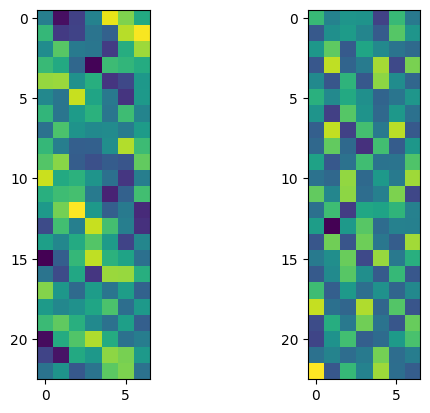

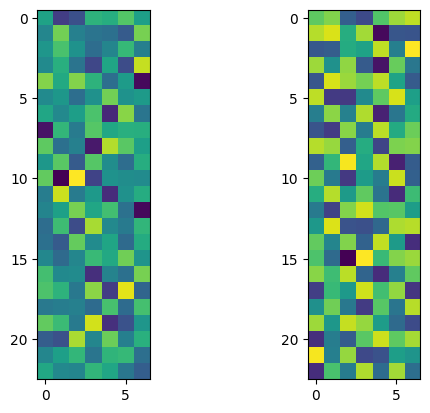

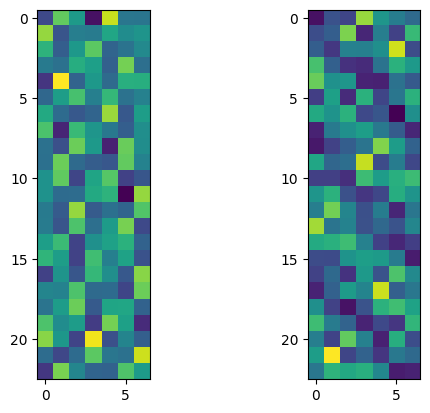

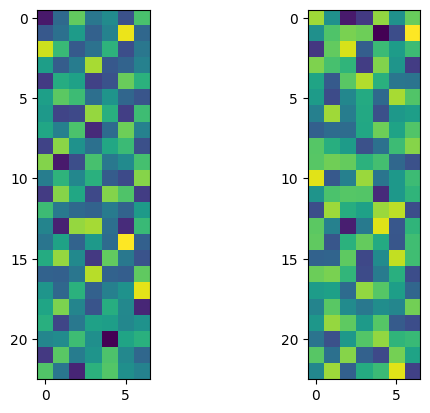

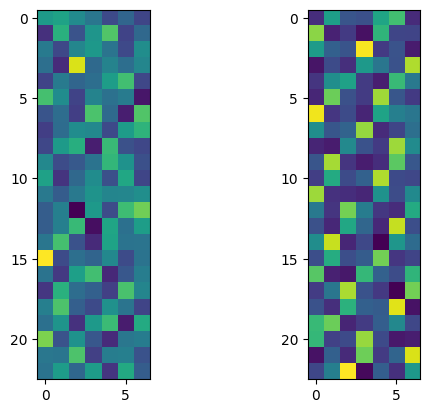

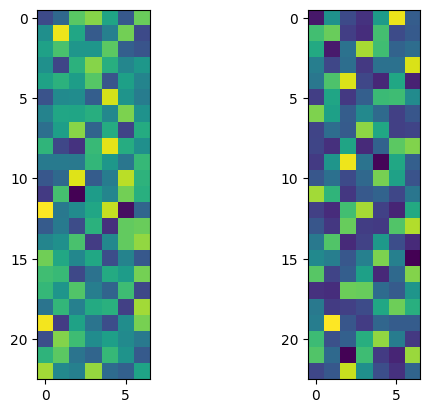

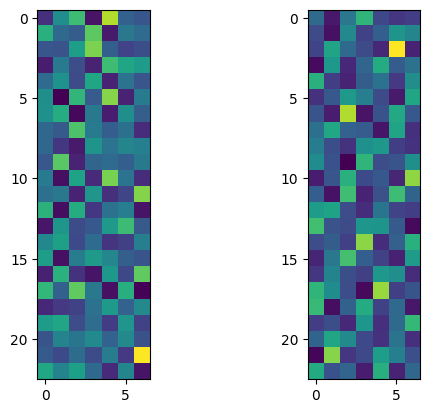

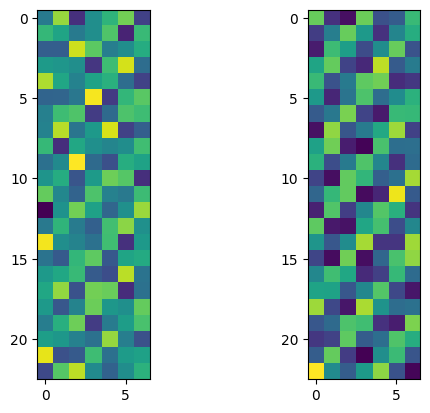

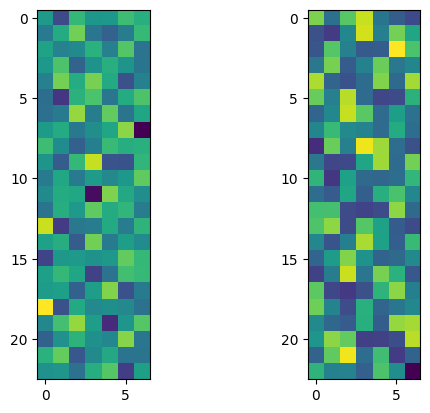

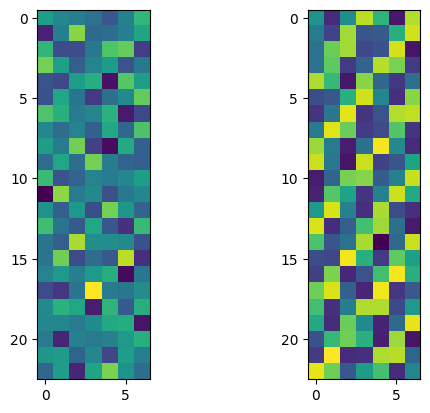

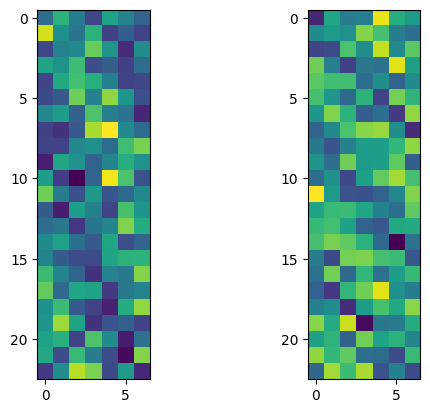

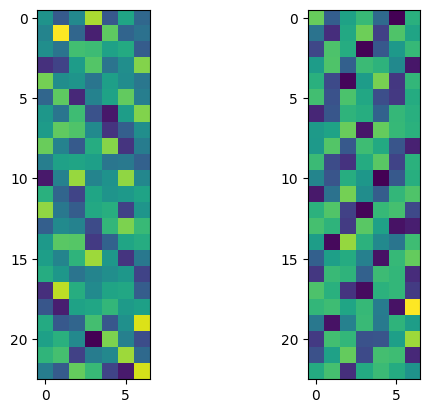

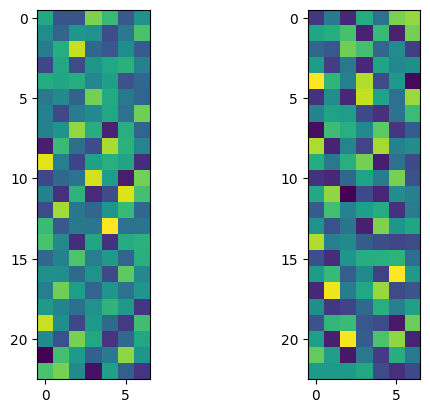

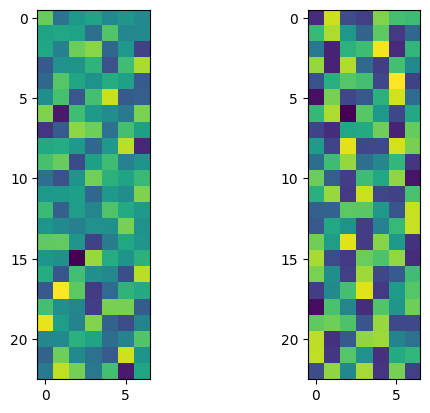

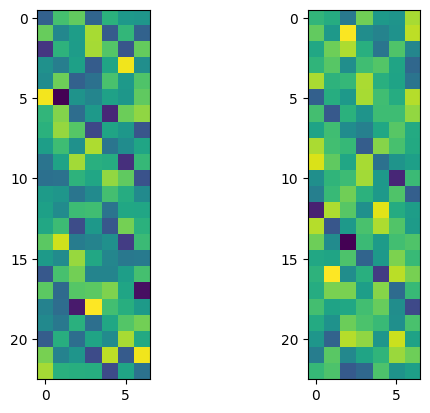

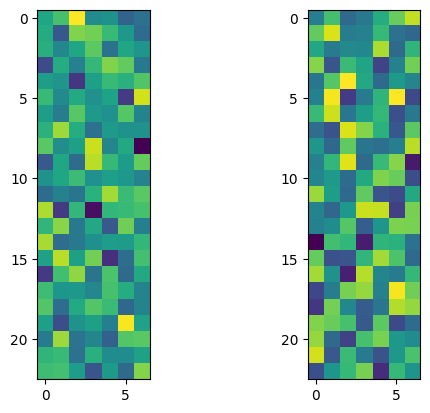

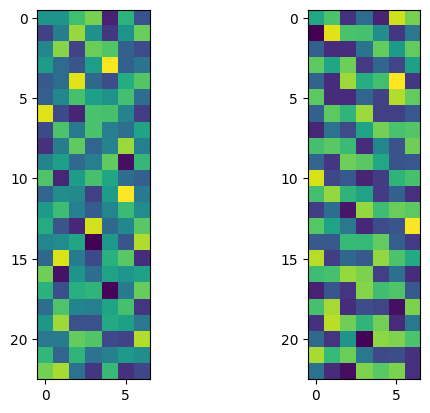

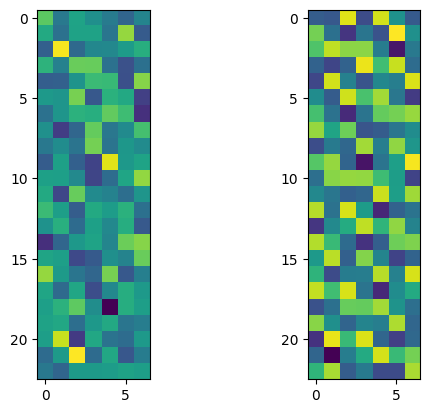

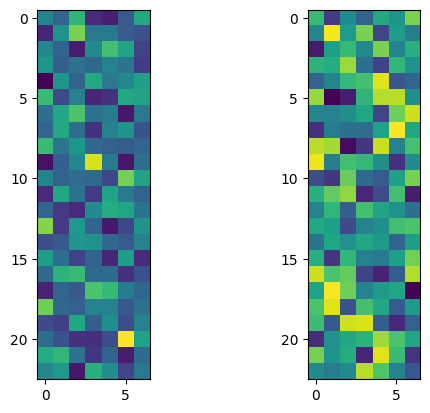

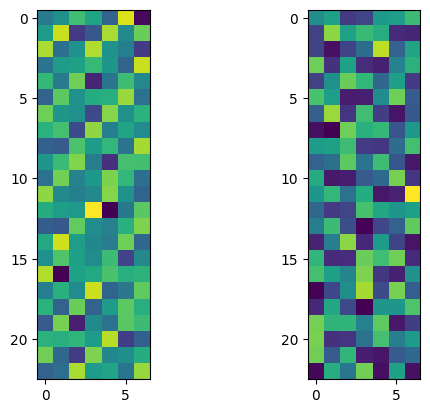

In [116]:
for i in range(embedding.shape[0]):
    plt.figure()
    plt.subplot(1, 2, 1)
    plt.imshow(embedding[i,:].reshape(23,7))
    plt.subplot(1, 2, 2)
    plt.imshow(lm_head[:,i].reshape(23,7))
    


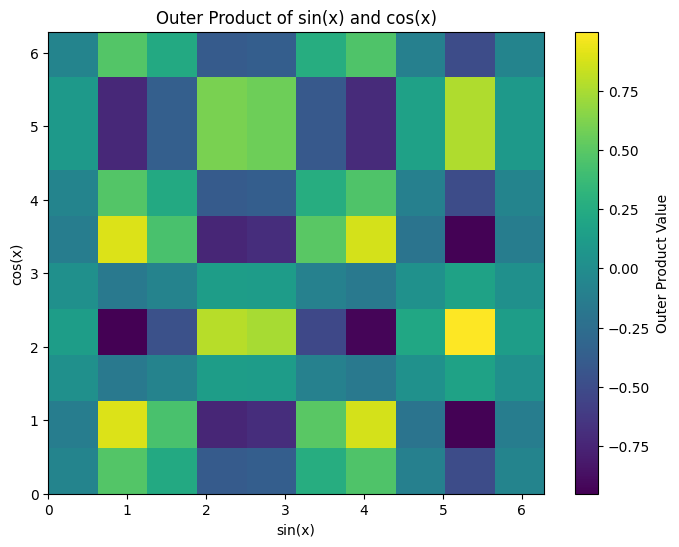

In [140]:
import numpy as np
import matplotlib.pyplot as plt

# Define the x values for the sinusoid functions
x = np.linspace(0, 2 * np.pi, 10)

# Define the two sinusoid functions
y1 = np.sin(2*x + np.pi / 6)
y2 = np.sin(2*x - np.pi / 23)

# Calculate the outer product
outer_product = np.outer(y1, y2)

# Create a figure to display the outer product
plt.figure(figsize=(8, 6))
plt.imshow(outer_product, extent=(0, 2 * np.pi, 0, 2 * np.pi), origin='lower', aspect='auto')
plt.colorbar(label='Outer Product Value')
plt.title('Outer Product of sin(x) and cos(x)')
plt.xlabel('sin(x)')
plt.ylabel('cos(x)')
plt.show()